In [125]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean
import copy
import gym
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Let's Try Bayesian Optimization

#### Make Network

In [234]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

#### set up phase

In [235]:
max_x = 1000
n_start = 3
rates = torch.rand(n_start).mul(max_x)
rwrds = torch.zeros(n_start)
for rind, rr in enumerate(rates):
    rwrds[rind] = env.step(rr.unsqueeze(0))[1].item()
    


In [236]:
rates

tensor([772.6411, 420.4324, 139.4055])

In [237]:
bo = BayesOpt(rates, rwrds, normalize=True, max_x=max_x, acquisition=expected_improvement,
             max_jump=1000)

In [238]:
saved_rates = rates.clone()
saved_rwrds = rwrds.clone()
test_points = torch.arange(1, 1000).float().div(max_x)

## Call This Manually a Bunch of Times until You Want to Stop

torch.Size([1])
next rate =  tensor([814.0703])
tensor([-2.1025])


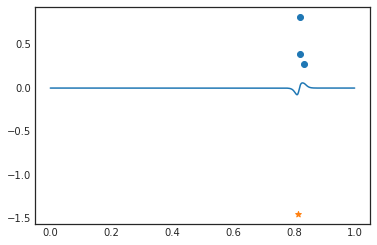

In [334]:

bo.train_surrogate(iters=250, overwrite=True)
next_rate = bo.acquire(explore=0.1).unsqueeze(0)
print(next_rate.shape)
print("next rate = ", next_rate)
rwrd = torch.tensor(env.step(next_rate.mul(bo.max_x))[1]).unsqueeze(0)
print(rwrd)
saved_rates = torch.cat((saved_rates, next_rate))
saved_rwrds = torch.cat((saved_rwrds, rwrd))



bo.update_obs(next_rate, rwrd, max_obs=4)
pred_mean = bo.get_pred_dist(test_points).mean.detach()
plt.scatter(bo.train_x[:-1], bo.train_y[:-1])
plt.scatter(bo.train_x[-1], bo.train_y[-1], marker='*')
plt.plot(test_points, pred_mean)
plt.show()

## Generate Both Ac. Function

In [335]:
bo_limited = BayesOpt(saved_rates[-4:], saved_rwrds[-4:], normalize=True, max_x=max_x, acquisition=expected_improvement,
             max_jump=400)

bo_limited.train_surrogate(iters=250, overwrite=True)

bo_unlimited = BayesOpt(saved_rates[-4:], saved_rwrds[-4:], normalize=True, max_x=max_x, acquisition=expected_improvement,
             max_jump=1000)
bo_unlimited.train_surrogate(iters=250, overwrite=True)

In [336]:
next_rate = bo_unlimited.acquire(explore=0.1).unsqueeze(0)
next_rate_limited = bo_limited.acquire(explore=0.1).unsqueeze(0)

hitting boundary
32
tensor(160.8040)
hitting boundary
8
tensor(437.6253)


In [337]:
print(next_rate)
print(next_rate_limited)

tensor([160.8040])
tensor([437.6253])


In [338]:
limited_env = copy.deepcopy(env)
limited_rwrd = torch.tensor(limited_env.step(next_rate_limited)[1]).unsqueeze(0)

In [339]:
unlimited_env = copy.deepcopy(env)
unlimited_rwrd = torch.tensor(unlimited_env.step(next_rate)[1]).unsqueeze(0)

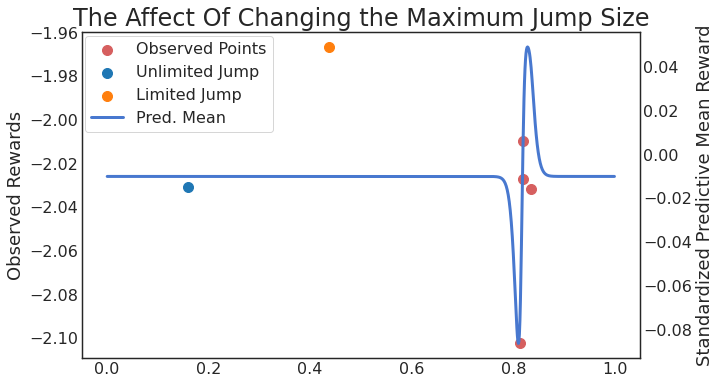

In [360]:
sns.set_style("white")
colors = sns.color_palette("muted", n_colors=10)

title_fs = 24
leg_fs = 16
ax_fs = 18

fig, ax = plt.subplots(figsize=(10, 6))
pred_mean = bo.get_pred_dist(test_points).mean.detach()
ax.scatter(saved_rates[-4:].div(max_x), saved_rwrds[-4:], s=100, color=colors[2],
          label="Observed Points")
ax.scatter(next_rate.div(max_x), unlimited_rwrd, s=100, label="Unlimited Jump")
ax.scatter(next_rate_limited.div(max_x), limited_rwrd, s=100, label="Limited Jump")
ax.set_ylabel("Observed Rewards", fontsize=ax_fs)

ax2 = ax.twinx()
ax2.set_ylabel("Standardized Predictive Mean Reward", fontsize=ax_fs)
ax2.plot(test_points, pred_mean, color=colors[0], linewidth=3, label="Pred. Mean")
fig.legend(bbox_to_anchor=(0.39, 0.825), fontsize=leg_fs, frameon=True)
ax.tick_params("both", labelsize=ax_fs-2)
ax2.tick_params("both", labelsize=ax_fs-2)

plt.title("The Affect Of Changing the Maximum Jump Size", fontsize=title_fs)
plt.savefig("./jump_size_instance.pdf", bbox_inches="tight")
plt.show()


In [298]:
limited_rwrd

tensor([-2.0376])

In [247]:
unlimited_rwrd

tensor([0.3655])